<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/6/6f/Programming123najra.gif" alt="Typing gif from Wikipedia" width="500px" />
</p>

# Spy Keypad

**Part 2 for working with audio signals**

---

## Overview

**A door is encoded with a number pad (0-9). We can't see the door, but through nefariouis means we have a recording of someone opening it. Quick! We need to decode this [mystery signal](https://github.com/ProjectPythia/wavelet-cookbook/blob/main/notebooks/data/mystery_signal.wav) and the order they appear to open the door!**

We know that the door code is set up as:
- A note: 0
- B note: 1
- C note: 2
- D note: 3
- E note: 4
- F note: 5

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Matplotlib](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Necessary | Used to plot data |
| [Intro to Pandas](https://foundations.projectpythia.org/core/pandas/pandas.html) | Necessary | Used to read in and organize data (in particular dataframes) |
| [Intro to Numpy](https://foundations.projectpythia.org/core/numpy/numpy-basics.html)| Necessary | Used to work with large arrays |
| [Intro to SciPy](https://docs.scipy.org/doc/scipy-1.13.1/tutorial/fft.html) | Helpful | Used to work with .wav files and built-in Fast Fourier Transform |

- **Time to learn**: 30 minutes

---

## Imports

In [7]:
import numpy as np                          # working with arrays
import pandas as pd                         # working with dataframes
from scipy.io import wavfile                # loading in wav files
import matplotlib.pyplot as plt             # plot data
from scipy.fftpack import fft, fftfreq      # working with Fourier Transforms

import pywt                                 # PyWavelets

## Extract audio .wav file
Like when working with the "Jingle Bells" song file, any .wav input file contains information about the amplitude at every point in the file. The frequency of the note will determine which chord each part of the piece represents

In [8]:
sampleRate, signalData = wavfile.read('../data/mystery_signal.wav')

duration = len(signalData) / sampleRate
time = np.arange(0, duration, 1/sampleRate) 

print(f"Sample Rate: {sampleRate}")
print(f"duration = {duration} seconds")
print(f"Total length in time steps = {len(time)}")

Sample Rate: 10000
duration = 6.0 seconds
Total length in time steps = 60000


## Let's Give the Data a Look!

It is always good practice to view the data that we have collected. First, let's organize the data into a `pandas` dataframe to organize the amplitude and time stamps

In [9]:
signal_df = pd.DataFrame({'time (seconds)': time, 'amplitude': signalData})
signal_df.head()

,time (seconds),amplitude
0,0.0000,11182
1,0.0001,29148
2,0.0002,2847
3,0.0003,14564
4,0.0004,21618


### Plot a Small Sample of the .wav File

Plot a small subsample of the .wav to visualize the input data

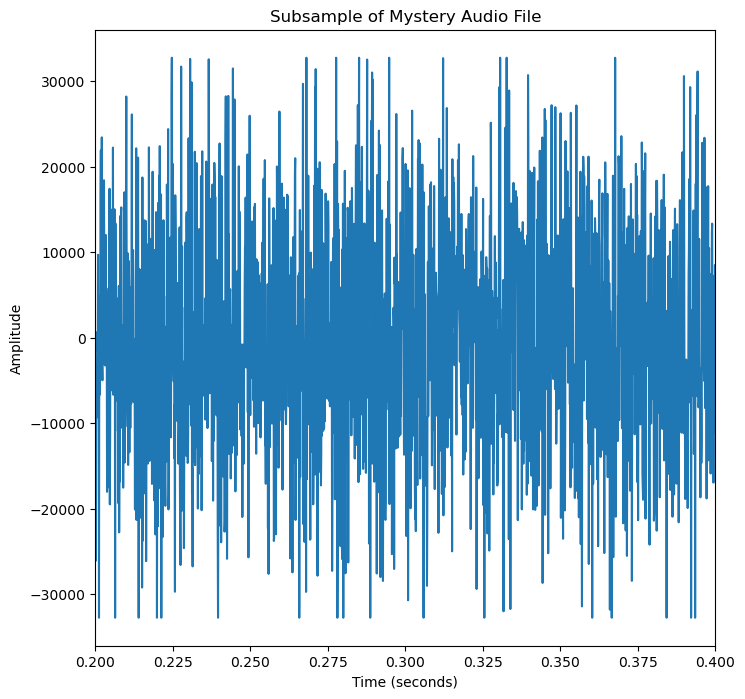

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
fig = plt.plot(signal_df["time (seconds)"], signal_df["amplitude"])
plt.title("Subsample of Mystery Audio File")
ax.set_xlim(signal_df["time (seconds)"][2000], signal_df["time (seconds)"][4000])
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

## Wavelet Analysis: Power Spectrum

The power spectrum plots the real component of the complex number returns from wavelet coefficents. This will return information about the frequency and time that we need to use to determine which notes are used in what order for the keypad

For the purpose of this example, we will use the Morlet mother wavelet. Morlet is one type of mother wavelet useful for working with audio signals and is a good general wavelet to start with when analyzing frequencies of a signal.

However, choosing which wavelet to use is an important step as different wavelets will be sensitive to different features in time-series data.

[To learn more!](https://www.mathworks.com/help/wavelet/gs/choose-a-wavelet.html)

In [11]:
wavelet_mother = "morl" # morlet mother wavelet

# scale determines how squished or stretched a wavelet is
scales = np.arange(1, 40)
wavelet_coeffs, freqs = pywt.cwt(signalData, scales, wavelet = wavelet_mother)

# Shape of wavelet transform
print(f"size {wavelet_coeffs.shape} with {wavelet_coeffs.shape[0]} scales and {wavelet_coeffs.shape[1]} time steps")
print(f"x-axis is: {wavelet_coeffs.shape[1]}")
print(f"y-axis is: {wavelet_coeffs.shape[0]}")

size (39, 60000) with 39 scales and 60000 time steps
x-axis is: 60000
y-axis is: 39


#### Plot Scalogram

We will be plotting the wavelet as a scalogram, where the presence of a strong match to a specific frequency will be a darker color. This will create distinct bands of a dark color where a specific frequency is present.

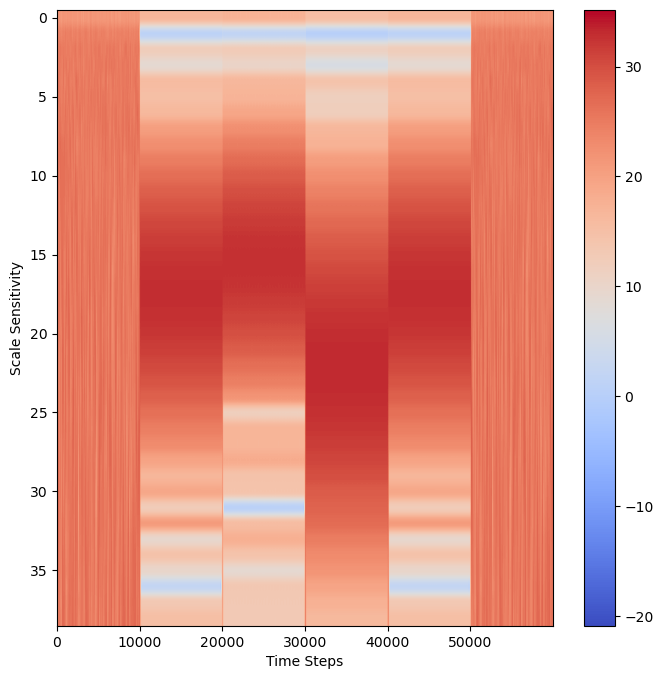

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
data = np.log2(np.square(abs(wavelet_coeffs))) # compare the magntiude
plt.xlabel("Time Steps")
plt.ylabel("Scale Sensitivity")
plt.imshow(data, 
           vmax=(data).max(), vmin=(data).min(),
           cmap="coolwarm", aspect="auto")
plt.colorbar()
plt.show()

## Behold! Distinct Bands of Frequencies!
Each distinct band represents a note. So, we can see that the data at the beginning at the end is random noise, with no distinct frequency. But at 1 second, a distinct note that lasts for 1 second, followed by three additional distinct bands. We now know the code is four numbers long. But now we need to determine what the numbers are and what their order is. Let's see where the possible note frequencies we have by overlaying the frequencies of each note onto the wavelet scalogram.

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Important Note</p>
   To convert HZ frequency to a <code>scale = hz *.0001</code> (where 0.01 is 100 Hz sampling) then apply <code>frequency2scale</code> PyWavelets function
</div>

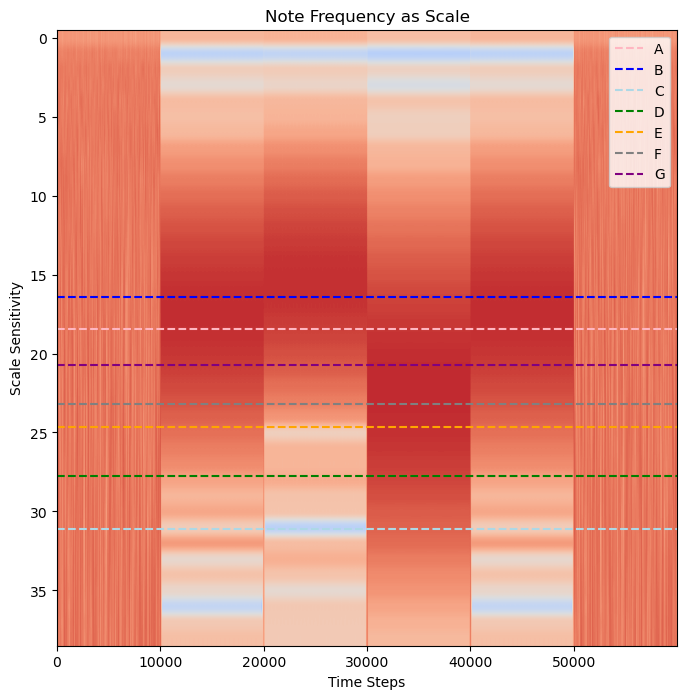

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))

# Overlay frequency of notes as dotted lines
sample_rate = 1/sampleRate
a_freq = pywt.frequency2scale(wavelet_mother, 440*sample_rate)
plt.axhline(y=a_freq, color='lightpink', linestyle='--', label='A') # A note: 440 hz
b_freq = pywt.frequency2scale(wavelet_mother, 494*sample_rate)
plt.axhline(y=b_freq, color="blue", linestyle='--', label='B') # B Note: 494 hz
c_freq = pywt.frequency2scale(wavelet_mother, 261*sample_rate)
plt.axhline(y=c_freq, color='lightblue', linestyle='--', label='C')       # C Note: 261 hz
d_freq = pywt.frequency2scale(wavelet_mother, 293*sample_rate)
plt.axhline(y=d_freq, color='green', linestyle='--', label='D')     # D Note: 293 hz
e_freq = pywt.frequency2scale(wavelet_mother, 330*sample_rate)
plt.axhline(y=e_freq, color='orange', linestyle='--', label='E')    # E Note: 330 hz
f_freq = pywt.frequency2scale(wavelet_mother, 350*sample_rate)
plt.axhline(y=f_freq, color='grey', linestyle='--', label='F')      # F Note: 350 hz
g_freq = pywt.frequency2scale(wavelet_mother, 392*sample_rate)
plt.axhline(y=g_freq, color='purple', linestyle='--', label='G')    # G Note: 392 hz

# Plot Power scalogram
power = np.log2(np.square(abs(wavelet_coeffs))) # compare the magntiude
plt.title("Note Frequency as Scale")
plt.xlabel("Time Steps")
plt.ylabel("Scale Sensitivity")
plt.imshow(power, 
           vmax=(power).max(), vmin=(power).min(),
           cmap="coolwarm", aspect="auto")
plt.legend()
plt.show()

## But Which Match Best?

We are looking for a note frequency that best lines up with the darkest part of each band. The first and the last band seem like the same note, but is it closer to an A note or a B note?

Let's see if we can use Fourier Transform to get a smaller range of notes to chose from

## Fast Fourier Transform

In [14]:
fourier_transform = abs(fft(signalData))
freqs = fftfreq(len(fourier_transform), sample_rate)

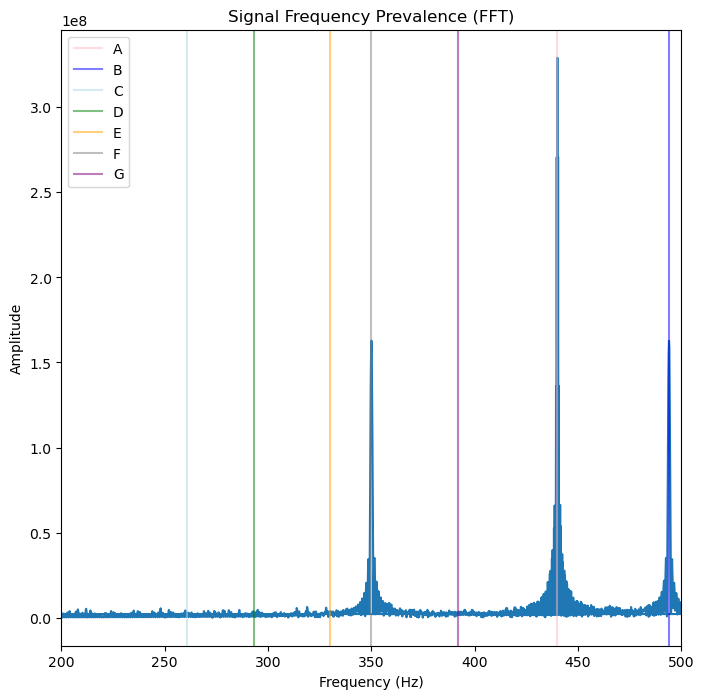

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(freqs, fourier_transform)
ax.set_xlim(left=200, right=500) 
plt.axvline(x=440, color="lightpink", label="A",alpha=0.5) # A note: 440 hz
plt.axvline(x=494, color="blue", label="B",alpha=0.5) # B Note: 494 hz
plt.axvline(x=261, color="lightblue", label="C",alpha=0.5)       # C Note: 261 hz
plt.axvline(x=293, color="green", label="D",alpha=0.5)     # D Note: 293 hz
plt.axvline(x=330, color="orange", label="E",alpha=0.5)    # E Note: 330 hz
plt.axvline(x=350, color="grey", label="F",alpha=0.5)      # F Note: 350 hz
plt.axvline(x=392, color="purple", label="G",alpha=0.5)    # G Note: 392 hz
plt.title("Signal Frequency Prevalence (FFT)")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

## Perfect, There are Three Notes!

Three notes stand out, and one note is used about twice as much as the other two: A, B, F

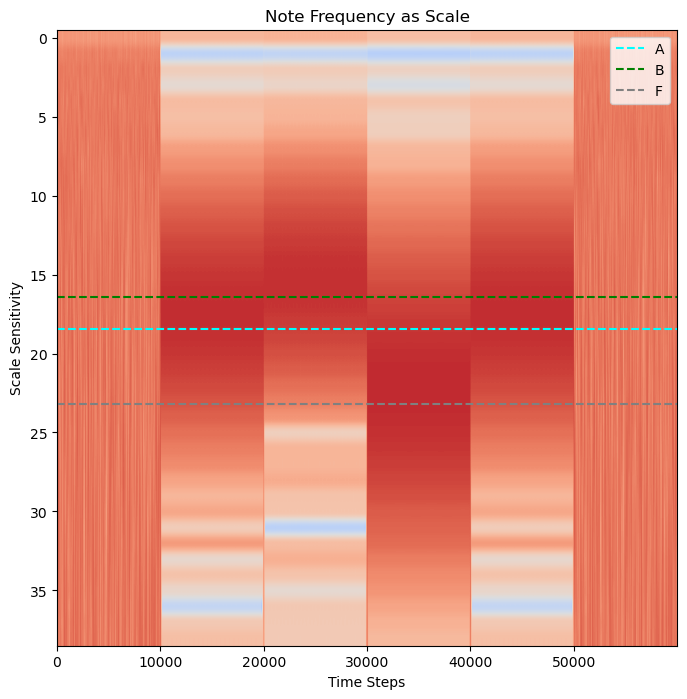

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))

# Overlay frequency of notes as dotted lines
sample_rate = 1/sampleRate
a_freq = pywt.frequency2scale(wavelet_mother, 440*sample_rate)
plt.axhline(y=a_freq, color='cyan', linestyle='--', label='A')
b_freq = pywt.frequency2scale(wavelet_mother, 494*sample_rate)
plt.axhline(y=b_freq, color="green", linestyle='--', label='B')
f_freq = pywt.frequency2scale(wavelet_mother, 350*sample_rate)
plt.axhline(y=f_freq, color='grey', linestyle='--', label='F')

# Plot Power scalogram
power = np.log2(np.square(abs(wavelet_coeffs))) # compare the magntiude
plt.title("Note Frequency as Scale")
plt.xlabel("Time Steps")
plt.ylabel("Scale Sensitivity")
plt.imshow(power, 
           vmax=(power).max(), vmin=(power).min(),
           cmap="coolwarm", aspect="auto")
plt.legend()
plt.show()

## Three Notes Played Over Six Seconds

We have the keypad solution! The three notes are played (sometimes repeated) over the course of the six seconds

### A, B, F, A


From our original problem, we know that the door code is set up as:
- A note: 0
- B note: 1
- C note: 2
- D note: 3
- E note: 4
- F note: 5

The solution to the door password is:

### 0, 1, 5, 0


---

## Summary
Now we've had a chance to work with unknown input values, but within an expected range. Different time-series data will have different ranges of expected frequencies, and with Fourier Transform and wavelet analysis it is possible to pull out such relevant data.

### What's next?

**Up next: apply wavelets transform and work with weather data!**